In [4]:
# 1. Imports and Setup  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('heart_disease_cleaned_advanced.csv')
print("Shape:", df.shape)


C:\Users\phill\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape: (303, 33)


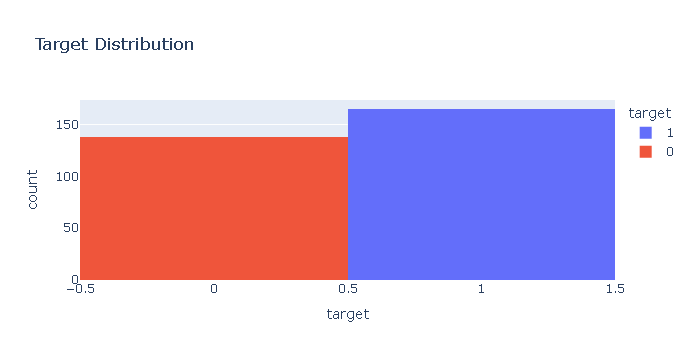

In [5]:
# 2. Descriptive Statistics and Target Distribution


df.describe(include='all').T

# Target distribution
fig = px.histogram(df, x='target', title='Target Distribution', color='target')
fig.show()

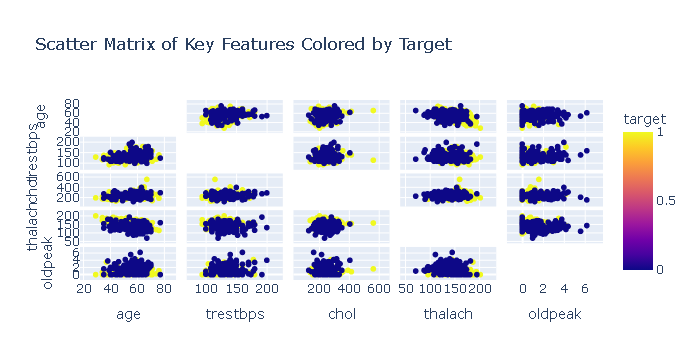

In [6]:
# 3. Interactive Pairplot with Key Features


# Select key numeric features
key_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']
fig = px.scatter_matrix(df[key_features], dimensions=key_features[:-1], color='target',
                        title='Scatter Matrix of Key Features Colored by Target')
fig.update_traces(diagonal_visible=False)
fig.show()


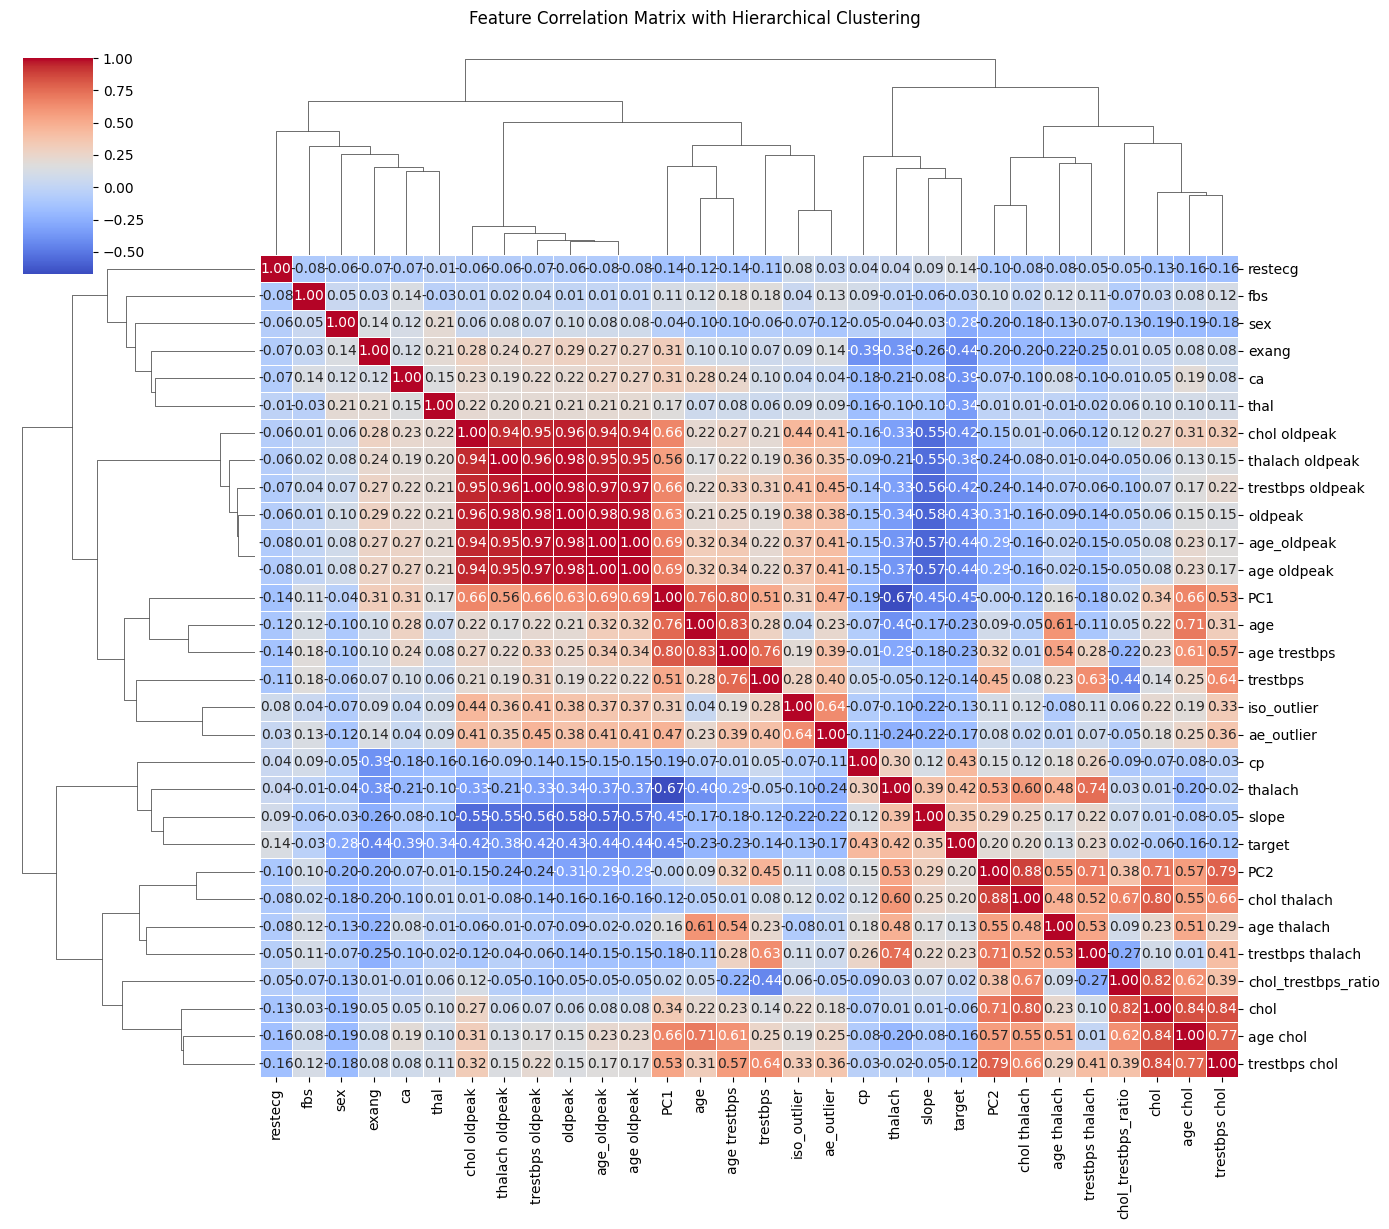

In [15]:
# 4. Correlation Heatmap with Hierarchical Clustering 

#fix 

# 1. Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# 2. IMPORTANT: Remove columns with zero variance (all values are the same)
# This prevents division-by-zero errors in correlation
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]

# 3. Compute correlation and fill any remaining NaNs with 0
corr = numeric_df.corr().fillna(0)

# 4. Plot with seaborn 
# Note: Do NOT use plt.figure() before clustermap, use the figsize inside the function
g = sns.clustermap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    linewidths=0.5,
    figsize=(14, 12)  # Set size here
)

# Access the underlying figure to add a title
g.fig.suptitle('Feature Correlation Matrix with Hierarchical Clustering', y=1.02)
plt.show()

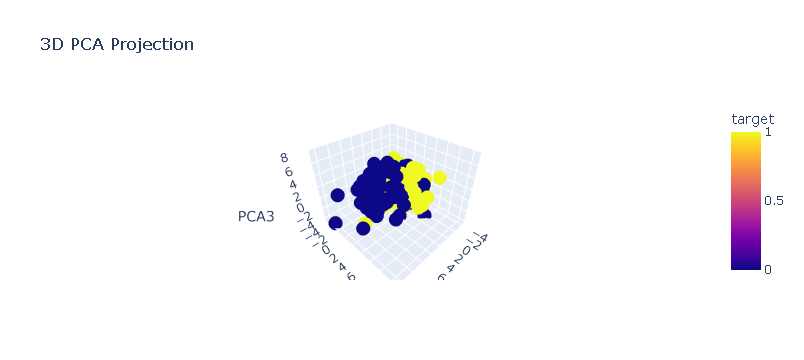

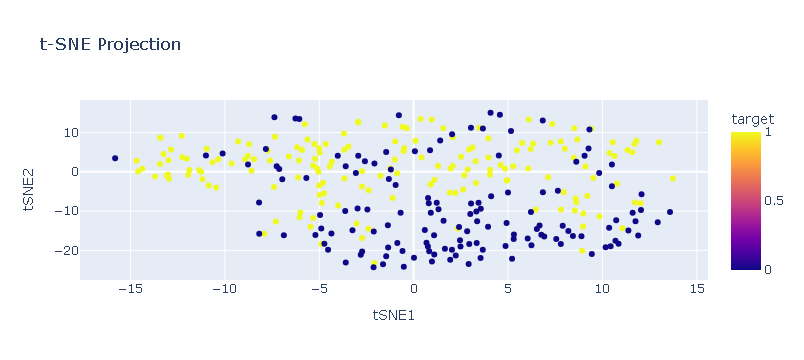

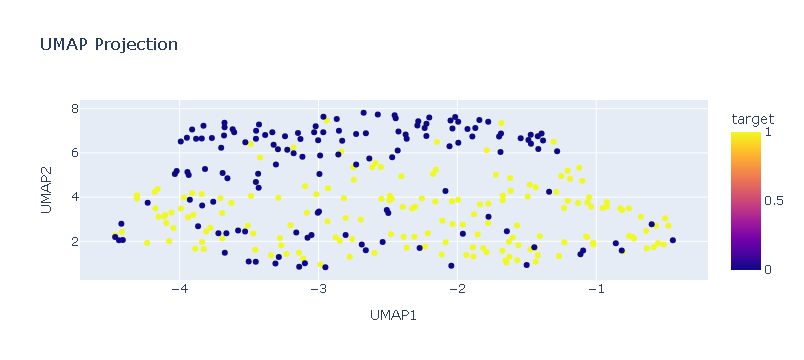

In [16]:
# 5. Advanced Dimensionality Reduction: PCA, t-SNE, UMAP 

# Prepare scaled data for all numeric features (excluding target, outlier flags, and categoricals)
features = df.select_dtypes(include=[np.number]).drop(columns=['target', 'iso_outlier', 'dbscan_outlier', 'ae_outlier', 'outlier_any', 'PC1', 'PC2'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled)
df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]
df['PCA3'] = pca_result[:,2]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled)
df['tSNE1'] = tsne_result[:,0]
df['tSNE2'] = tsne_result[:,1]

# UMAP
reducer = umap.UMAP(random_state=42)
umap_result = reducer.fit_transform(scaled)
df['UMAP1'] = umap_result[:,0]
df['UMAP2'] = umap_result[:,1]

# 3D PCA plot
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3', color='target',
                    title='3D PCA Projection')
fig.show()

# 2D t-SNE plot
fig = px.scatter(df, x='tSNE1', y='tSNE2', color='target', title='t-SNE Projection')
fig.show()

# 2D UMAP plot
fig = px.scatter(df, x='UMAP1', y='UMAP2', color='target', title='UMAP Projection')
fig.show()


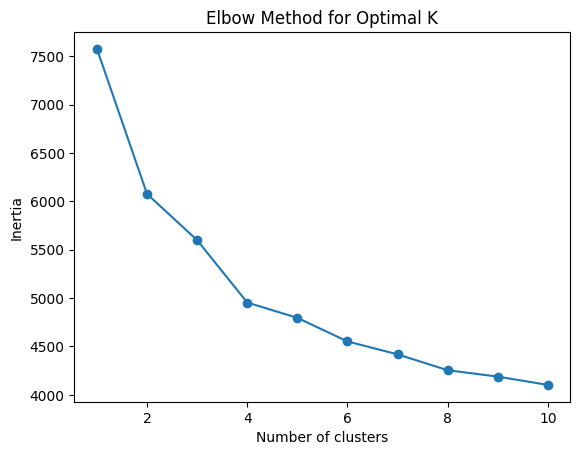

K-Means vs Target:
 kmeans_cluster    0   1
target                 
0                50  88
1               146  19

GMM vs Target:
 gmm_cluster    0   1
target              
0             41  97
1            129  36

Spectral vs Target:
 spectral_cluster    0   1
target                   
0                  53  85
1                 152  13


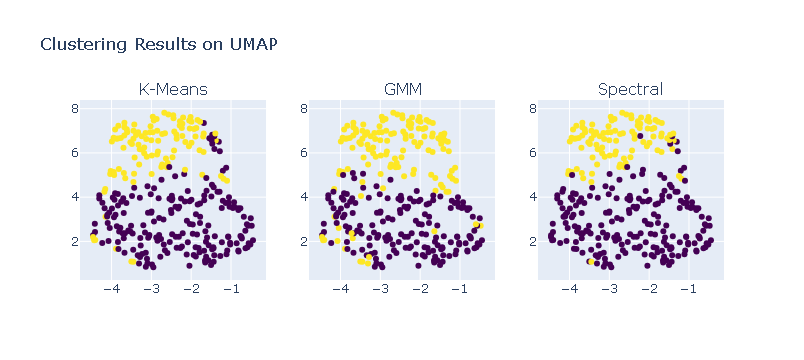

In [17]:
# 6. Clustering Analysis 

# K-Means (we already did, but now with optimal k using elbow method)
from sklearn.cluster import KMeans
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Optimal k=2 or 3? We'll use 2 for comparison.
kmeans = KMeans(n_clusters=2, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(scaled)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=2, random_state=42, affinity='nearest_neighbors')
df['spectral_cluster'] = spectral.fit_predict(scaled)

# Compare clusters with true target
print("K-Means vs Target:\n", pd.crosstab(df['target'], df['kmeans_cluster']))
print("\nGMM vs Target:\n", pd.crosstab(df['target'], df['gmm_cluster']))
print("\nSpectral vs Target:\n", pd.crosstab(df['target'], df['spectral_cluster']))

# Visualize clusters on UMAP
fig = make_subplots(rows=1, cols=3, subplot_titles=('K-Means', 'GMM', 'Spectral'))
fig.add_trace(go.Scatter(x=df['UMAP1'], y=df['UMAP2'], mode='markers',
                         marker=dict(color=df['kmeans_cluster'], colorscale='Viridis'), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=df['UMAP1'], y=df['UMAP2'], mode='markers',
                         marker=dict(color=df['gmm_cluster'], colorscale='Viridis'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=df['UMAP1'], y=df['UMAP2'], mode='markers',
                         marker=dict(color=df['spectral_cluster'], colorscale='Viridis'), showlegend=False), row=1, col=3)
fig.update_layout(title='Clustering Results on UMAP')
fig.show()

In [ ]:
# 7. Anomaly Detection with Autoencoder (Revisited) 

# We already computed autoencoder outliers; now analyze them.

# Compare outlier detection methods
outlier_cols = ['iso_outlier', 'dbscan_outlier', 'ae_outlier']
df['outlier_count'] = df[outlier_cols].sum(axis=1)

fig = px.histogram(df, x='outlier_count', title='Number of Outlier Flags per Patient')
fig.show()

# Examine outliers: higher oldpeak, lower thalach, etc.
print("Mean of features for outliers vs inliers:")
df.groupby('outlier_any')[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].mean()

